# Model-based Reinforcement Learning

<img src="https://raw.githubusercontent.com/jeremiedecock/polytechnique-inf639-2023-students/master/logo.jpg" style="float: left; width: 15%" />

[INF639-2023](https://moodle.polytechnique.fr/course/view.php?id=17866) Lab session #3

2019-2023 Jérémie Decock

[![Open in Google Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/jeremiedecock/polytechnique-inf639-2023-students/blob/master/lab3_mcts.ipynb)

[![My Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/jeremiedecock/polytechnique-inf639-2023-students/master?filepath=lab3_mcts.ipynb)

[![NbViewer](https://raw.githubusercontent.com/jupyter/design/master/logos/Badges/nbviewer_badge.svg)](https://nbviewer.jupyter.org/github/jeremiedecock/polytechnique-inf639-2023-students/blob/master/lab3_mcts.ipynb)

[![Local](https://img.shields.io/badge/Local-Save%20As...-blue)](https://github.com/jeremiedecock/polytechnique-inf639-2023-students/raw/master/lab3_mcts.ipynb)

## Introduction

In our preceding labs, we've delved into model-free approaches, encompassing both value-based and policy-based methods.

Model-free reinforcement learning methods learn directly from episodes of experience. They are called "model-free" because they do not need to know or learn the model of the environment (i.e., the reward and transition probability functions). Examples include Q-learning and policy gradients.

On the other hand, model-based reinforcement learning methods attempt to first learn a model of the environment (i.e., the reward and transition probability functions), and then use this model to make decisions. They can plan ahead by simulating future states in the model, which can lead to more efficient learning than model-free methods.

The aim of this lab is to provide an in-depth exploration of one of the most famous model-based reinforcement learning method: *Monte Carlo Tree Search (MCTS)*.

In this Python notebook, you will implement and assess this algorithm on the Naughts and Crosses board game.

You can either:
- open, edit and execute the notebook in *Google Colab* following this link: https://colab.research.google.com/github/jeremiedecock/polytechnique-inf639-2023-students/blob/master/lab3_mcts.ipynb ; this is the **recommended** choice as you have nothing to install on your computer
- open, edit and execute the notebook in *MyBinder* (if for any reason the Google Colab solution doesn't work): https://mybinder.org/v2/gh/jeremiedecock/polytechnique-inf639-2023-students/master?filepath=lab3_mcts.ipynb
- download, edit and execute the notebook on your computer if Python3 and JypyterLab are already installed: https://github.com/jeremiedecock/polytechnique-inf639-2023-students/raw/master/lab3_mcts.ipynb

If you work with Google Colab or MyBinder, **remember to save or download your work regularly or you may lose it!**

## Setup the Python environment

### Install required libraries

**Note**: This notebook relies on the graphviz tool.

If you are using Google Colab, the uncomment and execute the next cell to install dependencies.

In [1]:
# ! apt install graphviz

The operation couldn’t be completed. Unable to locate a Java Runtime that supports apt.
Please visit http://www.java.com for information on installing Java.



### Import required packages

In [1]:
from collections import deque
from copy import deepcopy
from functools import reduce
import math
import operator
import random
from typing import Optional, Any, List, Union, Callable

from IPython.display import Image   # To display graphviz images in the notebook

## Part 1: Monte Carlo Tree Search for Naughts and Crosses (Tic-Tac-Toe)

### The MCTS algorithm

Monte Carlo Tree Search (MCTS) is a model-based reinforcement learning algorithm that uses Monte Carlo simulation to evaluate actions in a decision-making problem. It's particularly effective in complex domains such as games, where it's not feasible to compute an exact solution.

Every time a decision is required, the MCTS algorithm performs the following steps for a specified number of simulations:
1. **Selection**: Start from the current root node and select successive child nodes down to a leaf node. The section path is determined by a *tree policy*.
2. **Expansion**: If the leaf node is not a terminal node (i.e., it does not end the game), then create one or more child nodes and select one.
3. **Simulation**: Run a simulated play of the game, either to the end of the game or a predetermined depth limit.
4. **Backpropagation**: Use the result of the game simulation to update information in the nodes on the path from the root to the leaf node.

The action leading to the child node with the highest value is then chosen.

<img src="https://github.com/jeremiedecock/polytechnique-inf639-2023-students/blob/master/mcts.png?raw=1" />

(source: Richard S. Sutton and Andrew G. Barto: "Reinforcement Learning: An Introduction")

Here is a pseudo-code version of the algorithm:

```
function MCTS(root):
    while within computational budget:
        leaf = selectNode(root)
        simulation_result = simulate(leaf)
        backpropagate(leaf, simulation_result)
    return bestChild(root)

function selectNode(node):
    while node is not a leaf:
        if not all children of node have been expanded:
            return expand(node)
        else:
            node = bestUCT(node)  # UCT = Upper Confidence bound applied to Trees
    return node

function expand(node):
    choose an unexpanded child of node
    create a new child node
    return the new child node

function simulate(node):
    simulate a random playout from node
    return the result of the playout

function backpropagate(node, result):
    while node is not null:
        update the node with the result
        node = node's parent

function bestChild(node):
    return child of node with the highest win ratio
```

Here's a brief explanation of each part:

- **MCTS Function**: It runs the main loop of the algorithm. Within the computational budget (like a time limit or a maximum number of iterations), it selects nodes, simulates games from those nodes, and then backpropagates the results.

- **Select Node**: This function traverses the tree from the root to a leaf node by using a selection policy like UCT (Upper Confidence bound applied to Trees).

- **Expand**: If the node has any untried actions, it creates a new child node for one of these actions.

- **Simulate**: From the new node, it simulates a random game (or a game with some heuristic-based decisions), often until a terminal state of the game is reached.

- **Backpropagate**: Once the simulation is complete, the results (like win/loss) are propagated back up the tree, updating the statistics (like win rate) of each node along the path from the leaf node to the root.

- **Best Child**: When the computational budget is exhausted, the child of the root with the highest win ratio (or another metric) is chosen as the move to make.

Further reading:

- Kocsis, Levente, and Csaba Szepesvári. "Bandit based monte-carlo planning." In European conference on machine learning, pp. 282-293. Berlin, Heidelberg: Springer Berlin Heidelberg, 2006. https://citeseerx.ist.psu.edu/document?repid=rep1&type=pdf&doi=6661e57237e4e8739b7a4946c4d3d4875376c068

- Browne, Cameron B., Edward Powley, Daniel Whitehouse, Simon M. Lucas, Peter I. Cowling, Philipp Rohlfshagen, Stephen Tavener, Diego Perez, Spyridon Samothrakis, and Simon Colton. "A survey of monte carlo tree search methods." IEEE Transactions on Computational Intelligence and AI in games 4, no. 1 (2012): 1-43. https://repository.essex.ac.uk/4117/1/MCTS-Survey.pdf

- Richard S. Sutton and Andrew G. Barto: "Reinforcement Learning: An Introduction", sect. 8.11, p.185 (http://incompleteideas.net/book/RLbook2020.pdf).

- Kamil Czarnogòrski, "Monte Carlo Tree Search – beginners guide", 2018 https://int8.io/monte-carlo-tree-search-beginners-guide/

### Exercise 1: Playout policy and simulate

Let's begin by implementing the rollout (aka playout) policy, also known as the rollout or default policy, which is utilized during the simulation phase (the third phase of the MCTS algorithm).

The subsequent two cells establish the Action and State classes for the [Naughts and Crosses environment](https://en.wikipedia.org/wiki/Tic-tac-toe) (also known as Tic-tac-toe). For this lab, we'll forgo the use of the Gym/Gymnasium framework in favor of a custom, tailored environment.

In [2]:
class NaughtsAndCrossesAction():
    """
    Represents an action in the game of Naughts and Crosses (Tic-Tac-Toe).

    Attributes
    ----------
    player : int
        The player making the action. 1 for 'X', -1 for 'O'.
    x : int
        The x-coordinate of the action on the game board.
    y : int
        The y-coordinate of the action on the game board.
    """

    def __init__(self, player: int, x: int, y: int):
        self.player = player
        self.x = x
        self.y = y

    def __str__(self) -> str:
        return str((self.x, self.y))

    def __repr__(self) -> str:
        return str(self)

    def __eq__(self, other: Any) -> bool:
        return self.__class__ == other.__class__ and self.x == other.x and self.y == other.y and self.player == other.player

    def __hash__(self) -> int:
        return hash((self.x, self.y, self.player))

In [3]:
class NaughtsAndCrossesState():
    """
    Represents the state of the game of Naughts and Crosses (Tic-Tac-Toe).

    Attributes
    ----------
    PLAYER_SYMBOLS : dict of int to str
        A dictionary mapping the player numerical values used internally to their symbols ('X' or 'O').
    board : list of list of int
        The game board represented as a 2D list.
    current_player : int
        The current player making a move. 1 for 'X', -1 for 'O'.
    """

    PLAYER_SYMBOLS = {
        1: "X",
        -1: "O"
    }

    def __init__(self):
        self.board: List[List[int]] = [[0, 0, 0], [0, 0, 0], [0, 0, 0]]
        self.current_player: int = 1

    def getCurrentPlayer(self) -> int:
        """
        Get the current player making a move.

        Returns
        -------
        int
            The current player. 1 for 'X', -1 for 'O'.
        """
        return self.current_player

    def getPossibleActions(self) -> List[NaughtsAndCrossesAction]:
        """
        Get a list of possible actions that the current player can take.

        Returns
        -------
        list of NaughtsAndCrossesAction
            A list of possible actions that the current player can take.
        """
        possible_actions = []
        for i in range(len(self.board)):
            for j in range(len(self.board[i])):
                if self.board[i][j] == 0:
                    possible_actions.append(NaughtsAndCrossesAction(player=self.current_player, x=i, y=j))
        return possible_actions

    def takeAction(self, action: NaughtsAndCrossesAction) -> "NaughtsAndCrossesState":
        """
        Take an action and return the resulting state.

        Parameters
        ----------
        action : NaughtsAndCrossesAction
            The action to take.

        Returns
        -------
        NaughtsAndCrossesState
            The resulting state after taking the action.
        """
        new_state = deepcopy(self)
        new_state.board[action.x][action.y] = action.player
        new_state.current_player = self.current_player * -1
        return new_state

    def isTerminal(self) -> bool:
        """
        Check if the current state is a terminal state (game over).

        Returns
        -------
        bool
            True if the state is terminal (game over), False otherwise.
        """
        for row in self.board:
            if abs(sum(row)) == 3:
                return True
        for column in list(map(list, zip(*self.board))):
            if abs(sum(column)) == 3:
                return True
        for diagonal in [[self.board[i][i] for i in range(len(self.board))],
                         [self.board[i][len(self.board) - i - 1] for i in range(len(self.board))]]:
            if abs(sum(diagonal)) == 3:
                return True
        return reduce(operator.mul, sum(self.board, []), 1)

    def getReward(self) -> Union[int, bool]:
        """
        Get the reward for the current state.

        Returns
        -------
        Union[int, bool]
            The reward value if the state is terminal, False otherwise.
        """
        for row in self.board:
            if abs(sum(row)) == 3:
                return sum(row) / 3
        for column in list(map(list, zip(*self.board))):
            if abs(sum(column)) == 3:
                return sum(column) / 3
        for diagonal in [[self.board[i][i] for i in range(len(self.board))],
                         [self.board[i][len(self.board) - i - 1] for i in range(len(self.board))]]:
            if abs(sum(diagonal)) == 3:
                return sum(diagonal) / 3
        return False

    def graphviz_str(self) -> str:
        output_str = ""
        for row in self.board:
            output_str += ''.join([NaughtsAndCrossesState.PLAYER_SYMBOLS[x].lower() if x in (-1, 1) else '_' for x in row]) + '\n'
        return output_str

    def __str__(self) -> str:
        output_str = f"Current player: {NaughtsAndCrossesState.PLAYER_SYMBOLS[self.current_player]}\n"
        for row in self.board:
            output_str += ' '.join([NaughtsAndCrossesState.PLAYER_SYMBOLS[x] if x in (-1, 1) else '_' for x in row]) + '\n'
        return output_str

In the context of Monte Carlo Tree Search (MCTS), the `random_policy` is used during the simulation phase of the algorithm. It's a type of rollout policy where actions are selected randomly from the set of available actions in each state.

The purpose of this policy is to provide an estimate of the value of a state by simulating the outcome of the game from that state to the end, under the assumption that both players play randomly. This estimate is then used to update the value of the state in the MCTS tree and guide the selection of actions in future simulations.

**Task 1.1**: implement the `random_policy`

In [4]:
def random_policy(state: NaughtsAndCrossesState) -> NaughtsAndCrossesAction:
    """
    Select a random action from the possible actions in the current state.

    Parameters
    ----------
    state : NaughtsAndCrossesState
        The current state of the game.

    Returns
    -------
    NaughtsAndCrossesAction
        A randomly selected action from the possible actions in the current state.
    """
    ### BEGIN SOLUTION ###

    possible_actions = state.getPossibleActions()
    action = random.choice(possible_actions)

    ### END SOLUTION ###

    return action

Now let's use this rollout policy in the simulate function.

The `simulate` function in Monte Carlo Tree Search (MCTS) is used to perform the simulation phase of the algorithm.

In this phase, the algorithm plays out a complete game or a certain number of steps from the current state, according to a specified policy (in this case, `rollout_policy`). The policy is typically a simple, fast-to-compute policy, such as choosing actions uniformly at random.

The purpose of the simulation is to obtain an estimate of the value of the current state. This estimate is then used to update the values of the states and actions in the MCTS tree, which guides the selection of actions in future simulations.

The `simulate` function has to continue to select actions and transition to new states until it reaches a terminal state (a state that ends the game). It then has to return the reward of the terminal state, which serves as the estimate of the value of the initial state.

**Task 1.2**: implement the `simulate` function

In [5]:
def simulate(state: NaughtsAndCrossesState, rollout_policy: Callable[[NaughtsAndCrossesState], NaughtsAndCrossesAction], verbose: bool = False) -> float:
        """
        Simulate a random game from the current state and return the reward value.

        This function serves as a random policy for the Monte Carlo Tree Search (MCTS) algorithm.

        Parameters
        ----------
        state : NaughtsAndCrossesState
            The current state of the game.
        rollout_policy : Callable[[NaughtsAndCrossesState], float]
            The policy for simulating random games from a state.
        verbose : bool
            Print all traversed states and taken actions.

        Returns
        -------
        float
            The reward value after simulating a random game from the current state.
        """
        while not state.isTerminal():

            ### BEGIN SOLUTION ###

            action = rollout_policy(state) # Play an action
            new_state = state.takeAction(action) # Set new state
            state = new_state
            
            ### END SOLUTION ###

            if verbose:
                print(f"State: {state}")
                print(f"Action: {action}")
                print()

        return state.getReward() # We return the reward associatedd with the terminal state

Now execute the following cell to check if your implementation works as intended.

**Task 1.3**: test the `random_policy` and the `simulate` function

In [14]:
state = NaughtsAndCrossesState()

reward = simulate(state, random_policy, verbose=True)

print(reward) # Reward belongs to {1, -1, False}

State: Current player: O
_ _ _
_ _ _
_ _ X

Action: (2, 2)

State: Current player: X
_ _ _
_ _ _
O _ X

Action: (2, 0)

State: Current player: O
_ _ _
_ X _
O _ X

Action: (1, 1)

State: Current player: X
_ _ _
_ X _
O O X

Action: (2, 1)

State: Current player: O
_ _ _
X X _
O O X

Action: (1, 0)

State: Current player: X
_ _ _
X X O
O O X

Action: (1, 2)

State: Current player: O
X _ _
X X O
O O X

Action: (0, 0)

1.0


### Exercise 2: the "expand" step

We will implement the `expand` function, but first, we define the `TreeNode` class. The `TreeNode` class is a data structure that represents a node in the MCTS tree. Each node corresponds to a state in the state space of the problem, and each edge corresponds to an action that transitions between states.

Here are some typical attributes of a `TreeNode`:

- `state`: The state in the state space that this node represents.
- `parent`: The parent node of this node in the MCTS tree. The root node has a `parent` of `None`.
- `children`: A dictionary mapping actions to child nodes. If an action leads from this node's state to another state, then `children[action]` is the `TreeNode` for that state.
- `is_fully_expanded`: A boolean flag indicating whether all possible actions from this node's state have been added to the `children` dictionary.
- `num_visits`: The number of times this node has been visited during the MCTS algorithm.
- `total_reward`: The total reward received during simulations that passed through this node. This is used to compute the average reward of this node, which is `total_reward / num_visits`.

In [15]:
class TreeNode():
    """
    Represents a node in the Monte Carlo Tree Search (MCTS) algorithm.

    Attributes
    ----------
    state : NaughtsAndCrossesState
        The state of the game at this node.
    is_terminal : bool
        True if the state is a terminal state, False otherwise.
    is_fully_expanded : bool
        True if all possible actions have been expanded, False otherwise.
    parent : TreeNode
        The parent node of this node.
    num_visits : int
        The number of times this node has been visited.
    total_reward : float
        The total reward accumulated at this node.
    children : dict of NaughtsAndCrossesAction to TreeNode
        A dictionary mapping actions to child nodes.
    """

    def __init__(self, state: NaughtsAndCrossesState, parent: Optional["TreeNode"]):
        self.state = state
        self.is_terminal = state.isTerminal()
        self.is_fully_expanded = self.is_terminal
        self.parent = parent
        self.num_visits = 0
        self.total_reward = 0
        self.children = {}

    def __str__(self) -> str:
        s = []
        s.append(f"total_reward: {self.total_reward}")
        s.append(f"num_visits: {self.num_visits}")
        s.append(f"is_terminal: {self.is_terminal}")
        s.append(f"possible_actions: {list(self.children.keys())}")
        return f"{self.__class__.__name__}: " + ', '.join(s)

    def to_graphiz(self, save_file_path: str = "mcts.dot", exploration_ratio: float = None):
        """
        Plots the tree with the current node as the root.

        Parameters
        ----------
        save_file_path : str, optional
            the path to save the plot (default is None, which means the plot will not be saved)
        """

        dot_str = "digraph G {\n"
        dot_str += "    node [shape=box];\n"

        # Build the graph and add the current node as the root.
        # Recursively adds nodes and edges to the graph `G`, assigns labels to nodes, and assigns colors to nodes.
        queue = deque([self])

        while len(queue) > 0:
            # Retrive the last element
            node = queue.popleft()

            if node.parent is not None:
                # Add the edge from the parent node to the current node
                parent_state_str = node.parent.state.graphviz_str()
                state_str = node.state.graphviz_str()
                if exploration_ratio is not None:
                    ucb_score_str = f"/{ucb(node, exploration_ratio)}"
                else:
                    ucb_score_str = ""
                dot_str += f'    "{node.parent.total_reward}/{node.parent.num_visits}{ucb_score_str}\n{parent_state_str}" -> "{node.total_reward}/{node.num_visits}\n{state_str}"\n'

            # Add child node into the queue
            queue.extend(node.children.values())

        dot_str += "}\n"

        with open(save_file_path, "w") as f:
            f.write(dot_str)

        return dot_str

The `expand` function in Monte Carlo Tree Search (MCTS) is used to perform the expansion phase of the algorithm.

In this phase, the algorithm chooses a leaf node from the current MCTS tree (i.e., a node that has not been expanded yet), and creates one or more child nodes corresponding to the actions that can be taken from the state represented by the leaf node. One of these child nodes is then selected for the simulation phase.

The purpose of the expansion phase is to grow the MCTS tree by exploring new states of the game. This allows the algorithm to gradually build up a more and more accurate representation of the value of each state and action, as more simulations are performed.

In the `expand` function, you should creates a new child node for each possible action from the current state, and adds these child nodes to the MCTS tree. You should then select one of these child nodes (typically at random) for the simulation phase.

**Task 2.1**: Implement the `expand` function

In [123]:
def expand(node: TreeNode) -> TreeNode:
    """
    Expand a node by adding a child node for each possible action.

    Parameters
    ----------
    node : TreeNode
        The node to expand.

    Returns
    -------
    TreeNode
        The newly added child node.
    """
    ### BEGIN SOLUTION ###

    possible_actions = node.state.getPossibleActions()
    # print(f'Parent node {node.state.getCurrentPlayer()}') 
    for action in possible_actions:
        if action not in node.children:
            next_state = node.state.takeAction(action)
            children_node = TreeNode(next_state, node) # Corresponding to next_state with the node passed in argument as parent
            node.children[action] = children_node
            if(len(possible_actions) == len(node.children)):
                node.is_fully_expanded = True
            
            return children_node # Adding only one child

    # random_chosen_action = random.choice(possible_actions)

    # return node.children[random_chosen_action]

    ### END SOLUTION ###

Now execute the following cell to check if your implementation works as intended.

**Task 2.2**: test the `expand` and `TreeNode.to_graphviz` functions

In [124]:
root_state = NaughtsAndCrossesState()
root_node = TreeNode(root_state, None)

new_node1 = expand(root_node)
new_node2 = expand(root_node)
new_node3 = expand(root_node)

new_node11 = expand(new_node1)
new_node12 = expand(new_node1)

new_node21 = expand(new_node2)

In [125]:
root_node.to_graphiz(save_file_path=f"lab3_mcts_test.dot");

In [126]:
!dot -Tpng lab3_mcts_test.dot > lab3_mcts_test.png

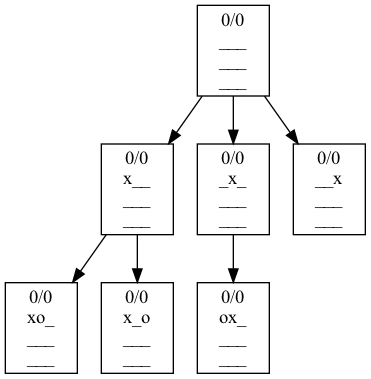

In [127]:
Image('lab3_mcts_test.png')

### Exercise 3: the "backpropagate" step

The `backpropagate` function in Monte Carlo Tree Search is used to perform the backpropagation phase of the algorithm.

In this phase, after a simulation has been performed and a reward has been obtained, the algorithm updates the information in the nodes on the path from the root to the leaf node that was expanded. This typically involves incrementing the `num_visits` attribute of each node on the path, and adding the reward to the `total_reward` attribute of each node.

The purpose of the backpropagation phase is to propagate the information obtained from the simulation back up the tree, so that it can guide the selection of actions in future simulations.

In your implementation, the `backpropagate` function has take as input a path of nodes and the reward obtained from the simulation, and updates the `num_visits` and `total_reward` attributes of each node on the path.

**Task 3.1**: implement the `backpropagate` function

In [128]:
def backpropagate(node: TreeNode, reward: float):
    """
    Backpropagate the reward value from a leaf node up to the root node.

    Parameters
    ----------
    node : TreeNode
        The leaf node where the simulation ended.
    reward : float
        The reward value obtained from the simulation.
    """
    ### BEGIN SOLUTION ###

## First version: Recursive function
    # if(node is None):
    #     return
    
    # node.total_reward += reward
    # node.num_visits += 1

    # return backpropagate(node.parent, reward)

## Second version: Classical Loop
    while node != None:
        node.num_visits += 1
        node.total_reward += reward
        # print(f'Reward {reward}, Parent {node.state.getCurrentPlayer()}')
        node = node.parent


    ### END SOLUTION ###

Now execute the following cell to check if your implementation works as intended.

**Task 3.2**: test the `backpropogate` function

In [129]:
root_state = NaughtsAndCrossesState()
root_node = TreeNode(root_state, None)

new_node1 = expand(root_node)
new_node2 = expand(root_node)
new_node3 = expand(root_node)

new_node11 = expand(new_node1)
new_node12 = expand(new_node1)

new_node21 = expand(new_node2)

In [130]:
root_node.to_graphiz(save_file_path=f"lab3_mcts_test.dot");

In [131]:
!dot -Tpng lab3_mcts_test.dot > lab3_mcts_test.png

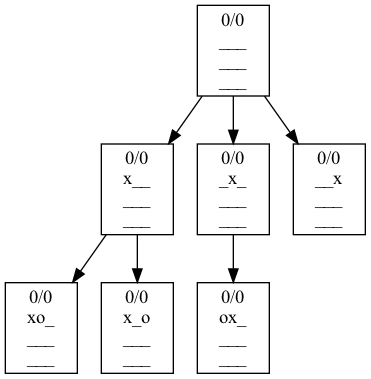

In [132]:
Image('lab3_mcts_test.png')

In [133]:
backpropagate(new_node12, 1.)
backpropagate(new_node12, 1.)
backpropagate(new_node12, 0.)

backpropagate(new_node11, 1.)
backpropagate(new_node21, -1.)


In [134]:
root_node.to_graphiz(save_file_path=f"lab3_mcts_test.dot");

In [135]:
!dot -Tpng lab3_mcts_test.dot > lab3_mcts_test.png

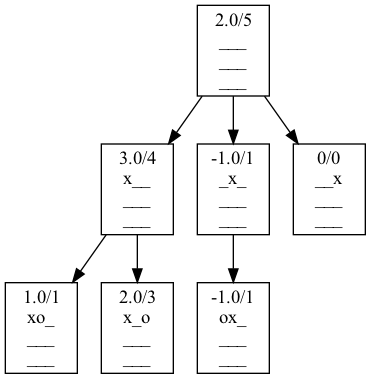

In [136]:
Image('lab3_mcts_test.png')

### Exercise 4: The "tree policy" and the UCB

The Upper Confidence Bound (UCB) formula is used during the selection phase (the first step) of Monte Carlo Tree Search.
In this phase, starting from the root node, the algorithm selects the best child node according to a certain criterion, and continues this process until it reaches a leaf node. The criterion for selecting the best child is typically the Upper Confidence Bound (UCB) formula, which balances the exploitation of child nodes with high average reward and the exploration of child nodes with few visits.

The USB formula is usually written as follows

$$
\text{UCB} = \frac{w_a}{n_a} + c \sqrt{\frac{\ln n}{n_a}}
$$

Where:

- $w_a$​ is the number of wins in child $a$.
- $n_a$​ is the number of times child $a$ has been visited.
- $n$​ is the number of times the parent node has been visited.
- $c$ is the exploration parameter, which is a constant determining the balance between exploration and exploitation. In practice, this is often set to a value that provides a good balance in the specific context (like $\sqrt{2}$ in many board games).

This formula balances two aspects: the exploitation of known good moves (represented by $\frac{w_a}{n_a}​​$), and the exploration of less-tried moves (represented by $c \sqrt{\frac{\ln⁡ n}{n_a}}$​). The constant $c$ adjusts how much the algorithm favors exploration over exploitation.

**Task 4.1**: Implement the `ucb` function below.

In [137]:
def ucb(node: TreeNode, exploration_ratio: float) -> float:
    """
    Calculate the Upper Confidence Bound (UCB) for a node.

    Parameters
    ----------
    parent_node : TreeNode
        The parent node.
    node : TreeNode
        The node for which the UCB is calculated.
    exploration_ratio : float
        The exploration ratio for balancing exploration and exploitation.

    Returns
    -------
    float
        The calculated UCB value.
    """
    ### BEGIN SOLUTION ###

    if(node.num_visits == 0): # if we never visited a node, we set his ucb to +inf, as we want to explore it
        return math.inf
    
    exploitation_term = node.parent.state.getCurrentPlayer()*node.total_reward / node.num_visits # We want that both players play the best move, 
                                                                                                # so that player "O" (1) maximizes positive reward chance when selecting best child node
                                                                                                # and player "X" (-1) maximizes negative reward chance when selecting best child node
    # print(f'Node parent {node.parent.state.getCurrentPlayer()}, total reward {node.total_reward}')
    if node.parent==None: # We never enter in this case, 
        return exploitation_term
    
    # Computing the exploration term
    exploration_term = exploration_ratio*math.sqrt(math.log(node.parent.num_visits) / node.num_visits)
    node_value = exploitation_term + exploration_term

    ### END SOLUTION ###

    return node_value

Now execute the following cell to check if your implementation works as intended.

**Task 4.2**: test the ucb function

In [138]:
root_state = NaughtsAndCrossesState()
root_node = TreeNode(root_state, None)

new_node1 = expand(root_node)
new_node2 = expand(root_node)
new_node3 = expand(root_node)

new_node11 = expand(new_node1)
new_node12 = expand(new_node1)
new_node21 = expand(new_node2)

backpropagate(new_node12, 1.)
backpropagate(new_node12, 1.)
backpropagate(new_node12, 0.)

backpropagate(new_node11, 1.)
backpropagate(new_node21, -1.)


In [139]:
backpropagate(new_node21, -1.)

In [140]:
backpropagate(new_node3, 1.)

In [141]:
root_node.to_graphiz(save_file_path=f"lab3_mcts_test.dot");

In [142]:
!dot -Tpng lab3_mcts_test.dot > lab3_mcts_test.png

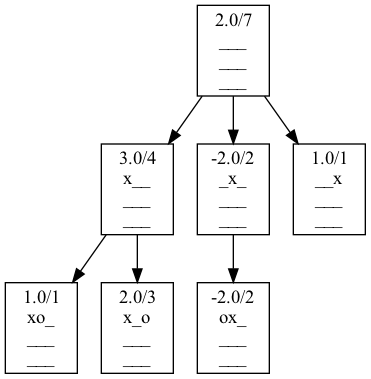

In [143]:
Image('lab3_mcts_test.png')

In [144]:
ucb(new_node11, exploration_ratio=1/math.sqrt(2))

-0.1674453888423023

In [145]:
ucb(new_node12, exploration_ratio=1/math.sqrt(2))

-0.18599103779970566

In [146]:
ucb(new_node21, exploration_ratio=1/math.sqrt(2))

1.416277305578849

As it is the X that must play next, we expect that the ucb is the highest for the leaf with the maximal proportion of negative reward (wihtout taking into account the exploration for so the little number of simulations we made here). Indeed, that is what we observe. The nodes `node11` ad `node12` where we simulated a $+1$ have negative ucb, whereas the `node21` where we simulated two $-1$ have  $ucb=1.4$

Like the UCB formula, the `get_best_child` function is used during the selection phase of the algorithm.
The `get_best_child` function computes the UCB value for each child of the input node, and returns the child with the highest UCB value.

**Task 4.3**: implement the `get_best_child` function.

In [147]:
def get_best_child(node: TreeNode, exploration_ratio: float) -> TreeNode:
    """
    Get the best child node based on the Upper Confidence Bound (UCB) formula.

    Parameters
    ----------
    node : TreeNode
        The parent node.
    exploration_ratio : float
        The exploration ratio for balancing exploration and exploitation.

    Returns
    -------
    TreeNode
        The best child node.
    """
    ### BEGIN SOLUTION ###

    children_nodes = node.children
    ucb_values = {}

    for action, child in children_nodes.items():
        ucb_values[child] = ucb(child, exploration_ratio)

    # Get the list of the best children 
    best_nodes = [node for node, ucb_value in ucb_values.items() if ucb_value == max(ucb_values.values())]

    ### END SOLUTION ###

    return random.choice(best_nodes)

Now execute the following cells to check if your implementation works as intended.

**Task 4.4**: test the `get_best_child`  function

In [159]:
root_state = NaughtsAndCrossesState()
root_node = TreeNode(root_state, None)

new_node1 = expand(root_node)
new_node2 = expand(root_node)
new_node3 = expand(root_node)

new_node11 = expand(new_node1)
new_node12 = expand(new_node1)
new_node21 = expand(new_node2)
new_node22 = expand(new_node2)

backpropagate(new_node12, 1.)
backpropagate(new_node12, 1.)
backpropagate(new_node12, 0.)

backpropagate(new_node11, 1.)
backpropagate(new_node21, -1.)
backpropagate(new_node21, -1.)
backpropagate(new_node22, 1.)
backpropagate(new_node22, 0)

In [160]:
root_node.to_graphiz(save_file_path=f"lab3_mcts_test.dot");

In [161]:
!dot -Tpng lab3_mcts_test.dot > lab3_mcts_test.png

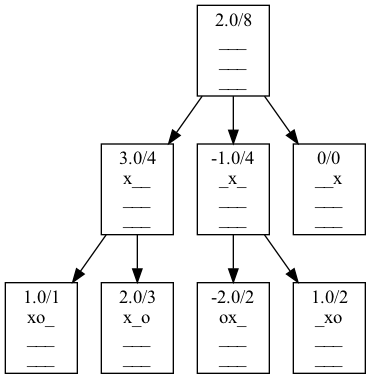

In [162]:
Image('lab3_mcts_test.png')

In [164]:
best_node = get_best_child(new_node1, exploration_ratio=1/math.sqrt(2))
print(best_node)
print(best_node.state)

TreeNode: total_reward: 1.0, num_visits: 1, is_terminal: 0, possible_actions: []
Current player: X
X O _
_ _ _
_ _ _



In [166]:
best_node = get_best_child(new_node2, exploration_ratio=1/math.sqrt(2))
print(best_node)
print(best_node.state)

TreeNode: total_reward: -2.0, num_visits: 2, is_terminal: 0, possible_actions: []
Current player: X
O X _
_ _ _
_ _ _



The `select_node` function in Monte Carlo Tree Search (MCTS) is the main function used to perform the selection phase of the algorithm.

The `select_node` function takes the root node as input, and returns the leaf node selected according to the UCB criterion. It also returns the path of nodes from the root to the selected leaf node. This path is used in the backpropagation phase to update the information in the nodes.

The `select_node` function iteratively selects the best child of the current node using the `get_best_child` function, until it reaches a leaf node.

**Task 4.5**: implement the `select_node` function

In [167]:
def select_node(node: TreeNode, exploration_ratio: float) -> TreeNode:
    """
    Select a node in the tree for expansion using the Upper Confidence Bound (UCB) formula.

    Parameters
    ----------
    node : TreeNode
        The current node in the tree.
    exploration_ratio : float
        The exploration ratio for selecting actions in the tree traversal phase.

    Returns
    -------
    TreeNode
        The selected node for expansion.
    """

    ### BEGIN SOLUTION ###

    while not node.state.isTerminal():

        if node.is_fully_expanded:
            node = get_best_child(node, exploration_ratio)
        else:
            return expand(node)
    

    ### END SOLUTION ###

    return node

Now execute the following cells to check if your implementation works as intended.

**Task 4.6**: test the `select_node`  function

In [186]:
root_state = NaughtsAndCrossesState()
root_node = TreeNode(root_state, None)

new_node1 = expand(root_node)
new_node2 = expand(root_node)
new_node3 = expand(root_node)

new_node11 = expand(new_node1)
new_node12 = expand(new_node1)

backpropagate(new_node12, 1.)
backpropagate(new_node12, 1.)
backpropagate(new_node12, 0.)

backpropagate(new_node11, 1.)

In [197]:
root_node.to_graphiz(save_file_path=f"lab3_mcts_test.dot");

In [188]:
!dot -Tpng lab3_mcts_test.dot > lab3_mcts_test.png

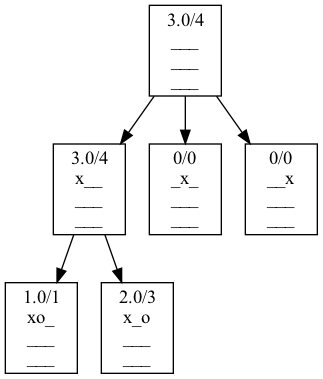

In [189]:
Image('lab3_mcts_test.png')

In [190]:
for i in range(9):
    selected_node = select_node(root_node, exploration_ratio=1/math.sqrt(2))
    backpropagate(selected_node, -1.)
    print(selected_node)
    print(selected_node.state)

TreeNode: total_reward: -1.0, num_visits: 1, is_terminal: 0, possible_actions: []
Current player: O
_ _ _
X _ _
_ _ _

TreeNode: total_reward: -1.0, num_visits: 1, is_terminal: 0, possible_actions: []
Current player: O
_ _ _
_ X _
_ _ _

TreeNode: total_reward: -1.0, num_visits: 1, is_terminal: 0, possible_actions: []
Current player: O
_ _ _
_ _ X
_ _ _

TreeNode: total_reward: -1.0, num_visits: 1, is_terminal: 0, possible_actions: []
Current player: O
_ _ _
_ _ _
X _ _

TreeNode: total_reward: -1.0, num_visits: 1, is_terminal: 0, possible_actions: []
Current player: O
_ _ _
_ _ _
_ X _

TreeNode: total_reward: -1.0, num_visits: 1, is_terminal: 0, possible_actions: []
Current player: O
_ _ _
_ _ _
_ _ X

TreeNode: total_reward: -1.0, num_visits: 1, is_terminal: 0, possible_actions: []
Current player: X
O X _
_ _ _
_ _ _

TreeNode: total_reward: -1.0, num_visits: 1, is_terminal: 0, possible_actions: []
Current player: X
O _ X
_ _ _
_ _ _

TreeNode: total_reward: -1.0, num_visits: 1, is_

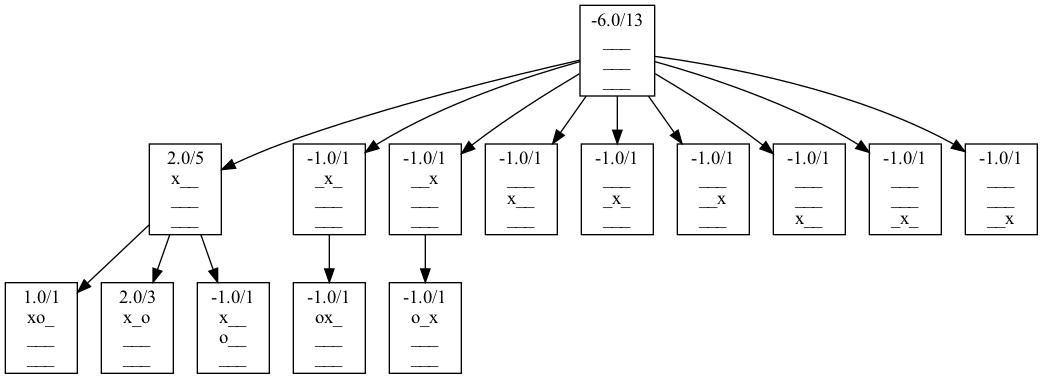

In [191]:
root_node.to_graphiz(save_file_path=f"lab3_mcts_test.dot")
!dot -Tpng lab3_mcts_test.dot > lab3_mcts_test.png
Image('lab3_mcts_test.png')

When expanding 9 times and backpropagating $-1$, ,the root node expands to all the possible states. Then, it selects those who have 0 as reward and  create children. Finally, when all children of root node are at $-1$ except the first one  (3/4), it selects this one because as it is the turn of **"O"** to play, and **"O"** wants to go towards the maximum positive reward rate ($3.4 > -1$)

In [366]:
# root_node.to_graphiz(save_file_path=f"lab3_mcts_test.dot")
# !dot -Tpng lab3_mcts_test.dot > lab3_mcts_test.png
# Image('lab3_mcts_test.png')
# find . -name "*step*.dot" -exec dot -0 -Tpng {} \;

### Exercise 5: Putting all together in the search function

Now, let's integrate all the components within the `search` method of the MCTS class.

**Task 5.1**: implement the `MCTS.search` function

In [209]:
class MCTS():
    """
    Monte Carlo Tree Search (MCTS) algorithm for the game of Naughts and Crosses (Tic-Tac-Toe).

    Attributes
    ----------
    exploration_ratio : float
        The exploration ratio for selecting actions in the tree traversal phase.
    rollout_policy : Callable[[NaughtsAndCrossesState], float]
        The policy for simulating random games from a state.
    """

    def __init__(self,
                 exploration_ratio: float = 1/math.sqrt(2),
                 rollout_policy: Callable[[NaughtsAndCrossesState], NaughtsAndCrossesAction] = random_policy):
        self.exploration_ratio = exploration_ratio
        self.rollout_policy = rollout_policy


    def search(self, current_state: NaughtsAndCrossesState, num_simulations: int = 1000, log_steps = False) -> NaughtsAndCrossesAction:
        """
        Perform the Monte Carlo Tree Search (MCTS) algorithm to select the best action to take for the given state.

        Parameters
        ----------
        initial_state : NaughtsAndCrossesState
            The current state of the game.
        num_simulations : int
            The number of simulations to perform.

        Returns
        -------
        NaughtsAndCrossesAction
            The best action to take according to the MCTS algorithm.
        """
        self.root = TreeNode(current_state, None)

        ### BEGIN SOLUTION ###

        for i in range(num_simulations):

            leaf = select_node(self.root, self.exploration_ratio)
            reward = simulate(leaf.state, self.rollout_policy)
            backpropagate(leaf, reward)

            if(log_steps):
                self.root.to_graphiz(save_file_path=f'step_by_step_{i}.dot')

        ### END SOLUTION ###

        best_child = get_best_child(self.root, 0)
        action = (action for action, node in self.root.children.items() if node is best_child).__next__()

        #print("expectedReward", bestChild.total_reward / bestChild.num_visits)
        return action

Now execute the following cells to check if your implementation works as intended.

**Task 5.2**: Test the MCTS algorithm

In [213]:
root_state = NaughtsAndCrossesState()
root_node = TreeNode(root_state, None)
root_node.to_graphiz(save_file_path=f"lab3_mcts_initial.dot");

mcts = MCTS()

state = root_state

i = 0
while not state.isTerminal():
    ### BEGIN SOLUTION ###

    action = mcts.search(state, num_simulations=1000, log_steps=False)
    state = state.takeAction(action)

    ### END SOLUTION ###

    print(f"State: {state}")
    print(f"Action: {action}")
    print()

    mcts.root.to_graphiz(save_file_path=f"lab3_mcts_{i}.dot")

    i += 1

!find . -name "*step*.dot" -exec dot -O -Tpng {} \;

State: Current player: O
_ _ _
_ X _
_ _ _

Action: (1, 1)

State: Current player: X
_ _ _
_ X _
_ _ O

Action: (2, 2)

State: Current player: O
_ _ _
_ X _
_ X O

Action: (2, 1)

State: Current player: X
_ O _
_ X _
_ X O

Action: (0, 1)

State: Current player: O
_ O _
_ X X
_ X O

Action: (1, 2)

State: Current player: X
_ O _
O X X
_ X O

Action: (1, 0)

State: Current player: O
_ O X
O X X
_ X O

Action: (0, 2)

State: Current player: X
_ O X
O X X
O X O

Action: (2, 0)

State: Current player: O
X O X
O X X
O X O

Action: (0, 0)



In [211]:
!dot -Tpng lab3_mcts_initial.dot > lab3_mcts_initial.png
Image('lab3_mcts_initial.png')

#### Display the MCTS Tree at some iterations

In [214]:
!dot -Tpng lab3_mcts_4.dot > lab3_mcts_4.png

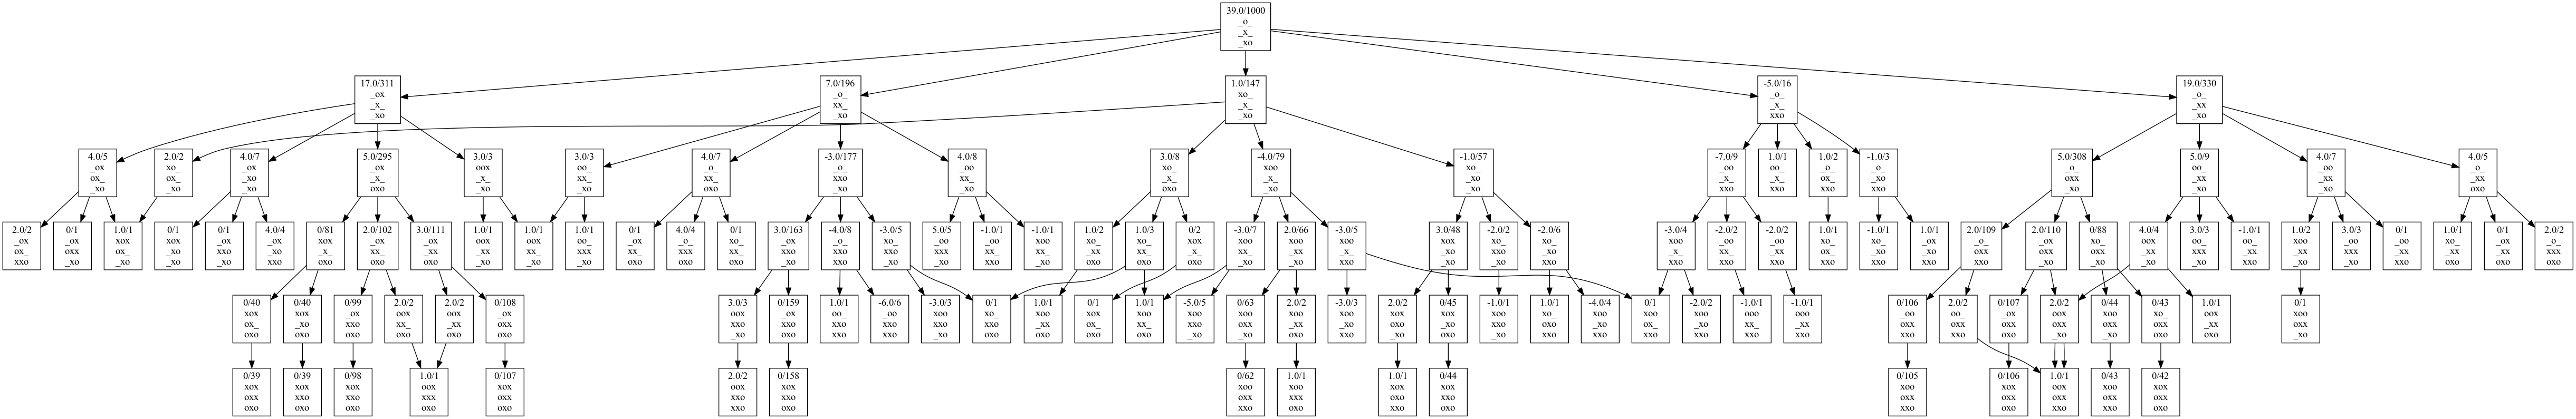

In [215]:
Image('lab3_mcts_4.png')

In [216]:
!dot -Tpng lab3_mcts_5.dot > lab3_mcts_5.png

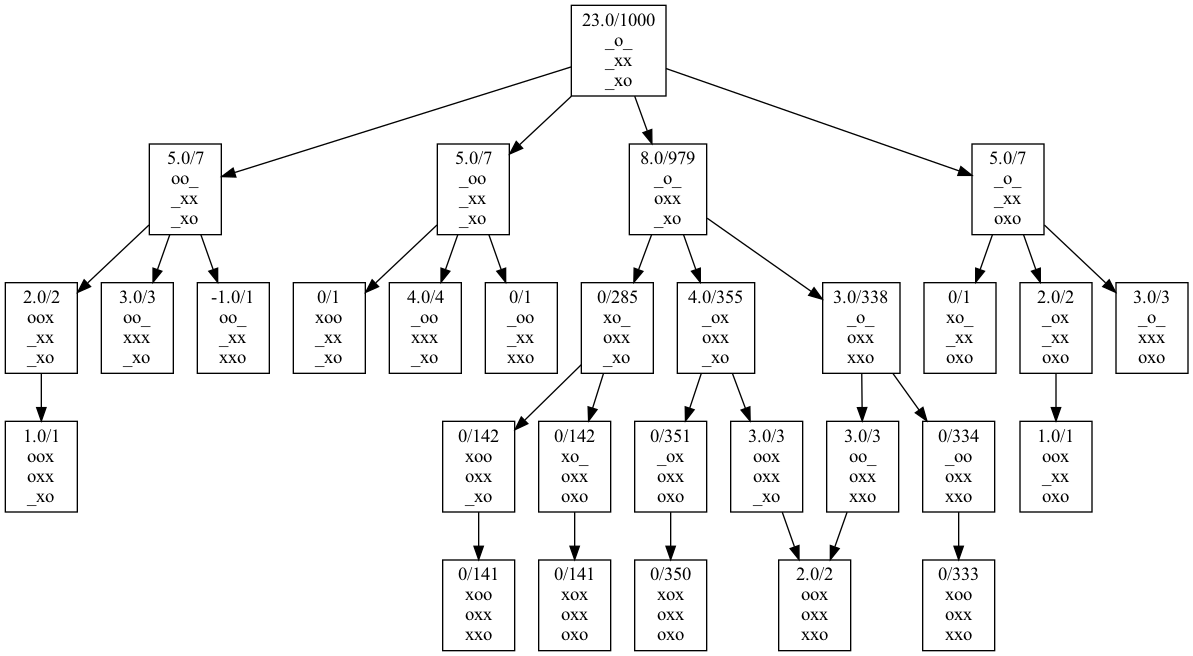

In [217]:
Image('lab3_mcts_5.png')

In [218]:
!dot -Tpng lab3_mcts_6.dot > lab3_mcts_6.png

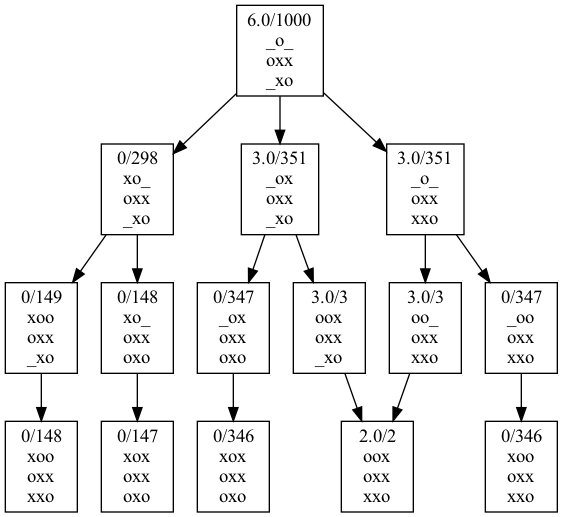

In [219]:
Image('lab3_mcts_6.png')

In [220]:
!dot -Tpng lab3_mcts_7.dot > lab3_mcts_7.png

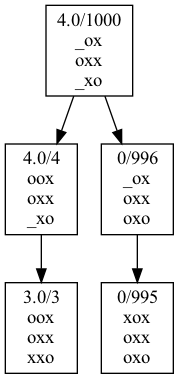

In [221]:
Image('lab3_mcts_7.png')

**Task 5.3**: change the `exploration_ratio` and watch the effect of this change on the graph. What do you observe?

In [229]:
root_state = NaughtsAndCrossesState()
root_node = TreeNode(root_state, None)
root_node.to_graphiz(save_file_path=f"lab3_mcts_initial.dot");

mcts = MCTS(exploration_ratio=2.)

state = root_state

i = 0
while not state.isTerminal():
    ### BEGIN SOLUTION ###

    action = mcts.search(state, num_simulations=1000, log_steps=False)
    state = state.takeAction(action)

    ### END SOLUTION ###

    print(f"State: {state}")
    print(f"Action: {action}")
    print()

    mcts.root.to_graphiz(save_file_path=f"lab3_mcts_exp1_{i}.dot")

    i += 1

!find . -name "*step*.dot" -exec dot -O -Tpng {} \;

State: Current player: O
_ _ _
_ X _
_ _ _

Action: (1, 1)

State: Current player: X
_ _ O
_ X _
_ _ _

Action: (0, 2)

State: Current player: O
_ _ O
_ X X
_ _ _

Action: (1, 2)

State: Current player: X
_ _ O
O X X
_ _ _

Action: (1, 0)

State: Current player: O
_ X O
O X X
_ _ _

Action: (0, 1)

State: Current player: X
_ X O
O X X
_ O _

Action: (2, 1)

State: Current player: O
_ X O
O X X
_ O X

Action: (2, 2)

State: Current player: X
O X O
O X X
_ O X

Action: (0, 0)

State: Current player: O
O X O
O X X
X O X

Action: (2, 0)



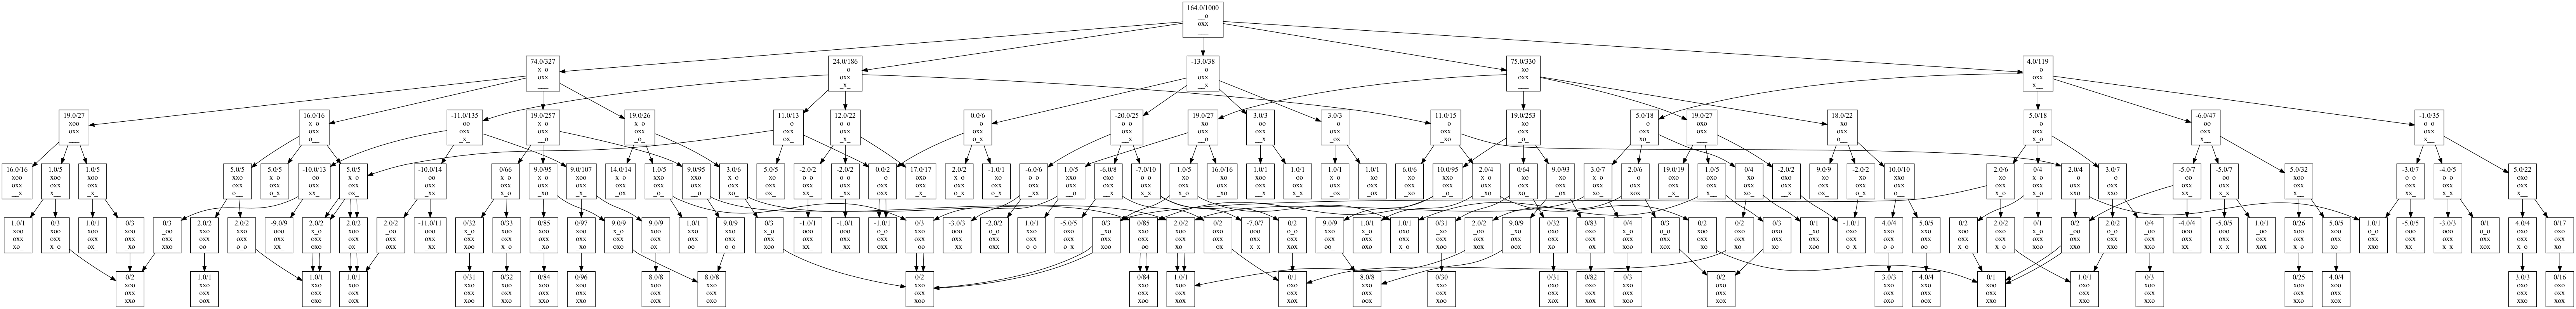

In [230]:
!dot -Tpng lab3_mcts_exp1_4.dot > lab3_mcts_exp1_4.png
Image('lab3_mcts_exp1_4.png')

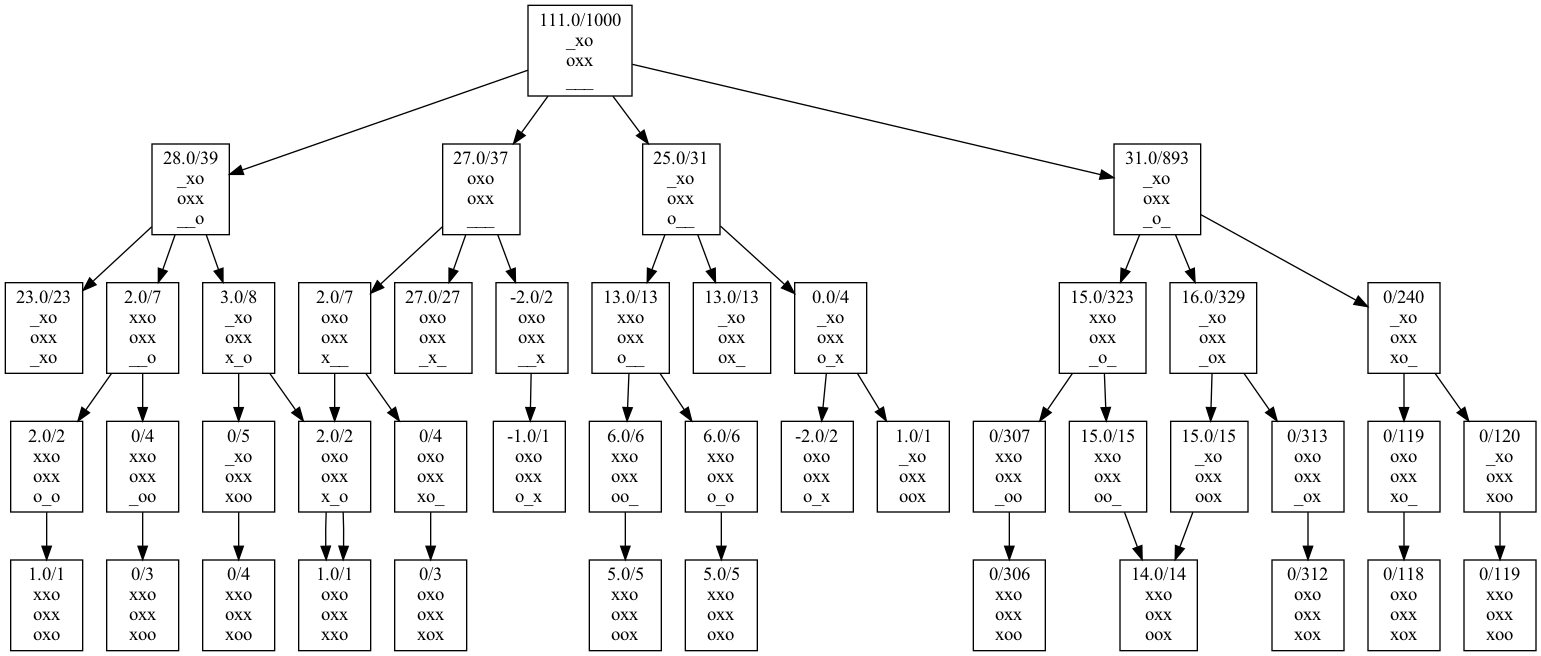

In [231]:
!dot -Tpng lab3_mcts_exp1_5.dot > lab3_mcts_exp1_5.png
Image('lab3_mcts_exp1_5.png')

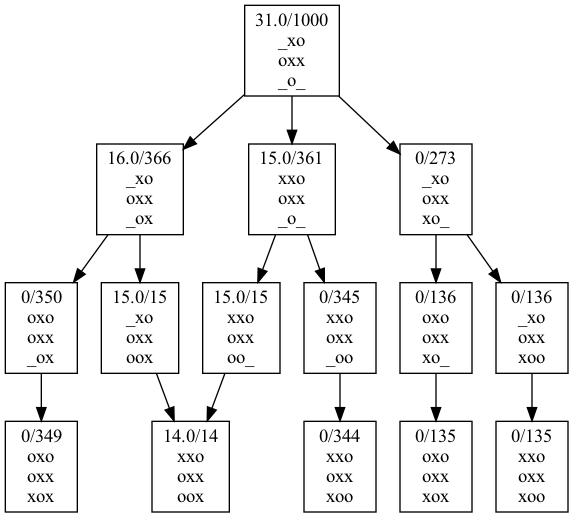

In [232]:
!dot -Tpng lab3_mcts_exp1_6.dot > lab3_mcts_exp1_6.png
Image('lab3_mcts_exp1_6.png')

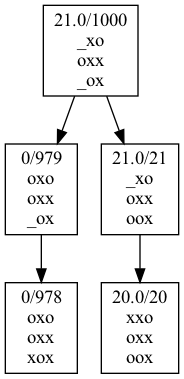

In [233]:
!dot -Tpng lab3_mcts_exp1_7.dot > lab3_mcts_exp1_7.png
Image('lab3_mcts_exp1_7.png')

**Observation:** Especially on `lab3_mcts_exp1_4`, we see that increasing the exploration rate tends to make the tree wider. Indeed, we tend to give more weights to unexplored leafs, so we explore more and more leafs.

In [234]:
root_state = NaughtsAndCrossesState()
root_node = TreeNode(root_state, None)
root_node.to_graphiz(save_file_path=f"lab3_mcts_initial.dot");

mcts = MCTS(exploration_ratio=0.1)

state = root_state

i = 0
while not state.isTerminal():
    ### BEGIN SOLUTION ###

    action = mcts.search(state, num_simulations=1000, log_steps=False)
    state = state.takeAction(action)

    ### END SOLUTION ###

    print(f"State: {state}")
    print(f"Action: {action}")
    print()

    mcts.root.to_graphiz(save_file_path=f"lab3_mcts_exp01_{i}.dot")

    i += 1

State: Current player: O
_ _ _
_ X _
_ _ _

Action: (1, 1)

State: Current player: X
O _ _
_ X _
_ _ _

Action: (0, 0)

State: Current player: O
O _ _
X X _
_ _ _

Action: (1, 0)

State: Current player: X
O _ _
X X O
_ _ _

Action: (1, 2)

State: Current player: O
O _ X
X X O
_ _ _

Action: (0, 2)

State: Current player: X
O _ X
X X O
O _ _

Action: (2, 0)

State: Current player: O
O _ X
X X O
O X _

Action: (2, 1)

State: Current player: X
O O X
X X O
O X _

Action: (0, 1)

State: Current player: O
O O X
X X O
O X X

Action: (2, 2)



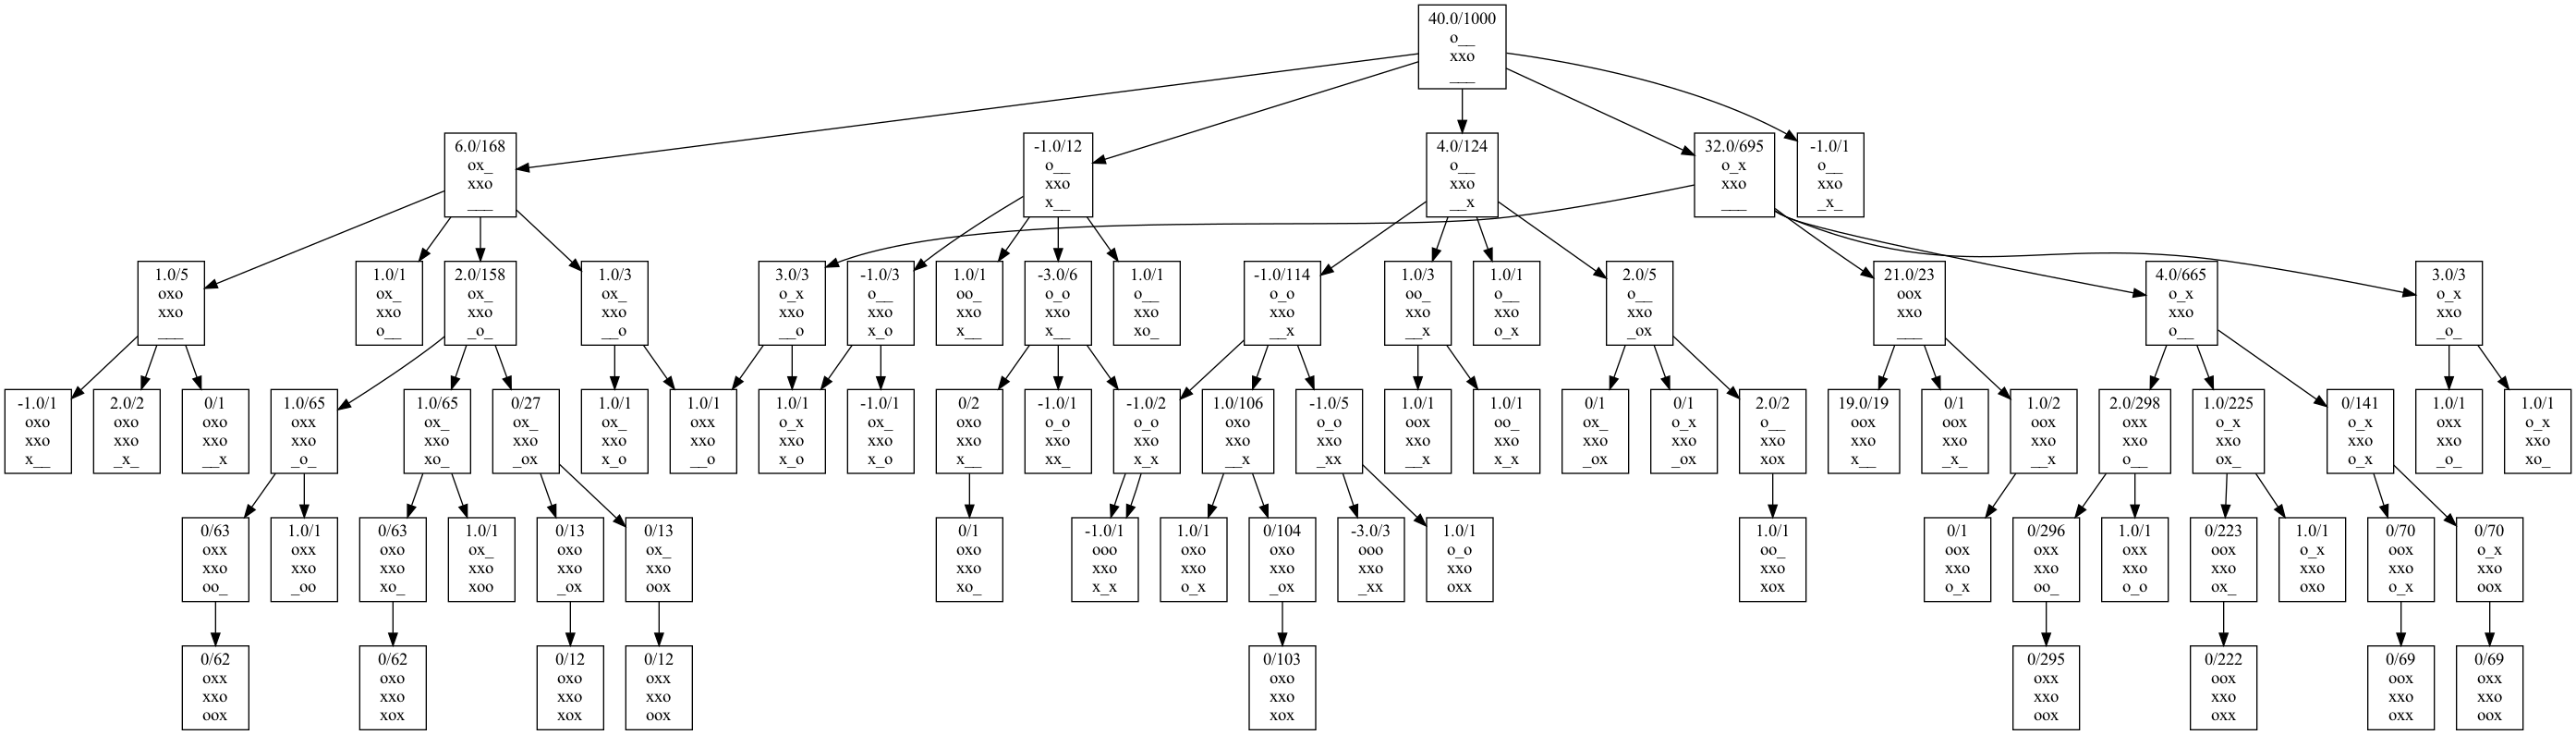

In [235]:
!dot -Tpng lab3_mcts_exp01_4.dot > lab3_mcts_exp01_4.png
Image('lab3_mcts_exp01_4.png')

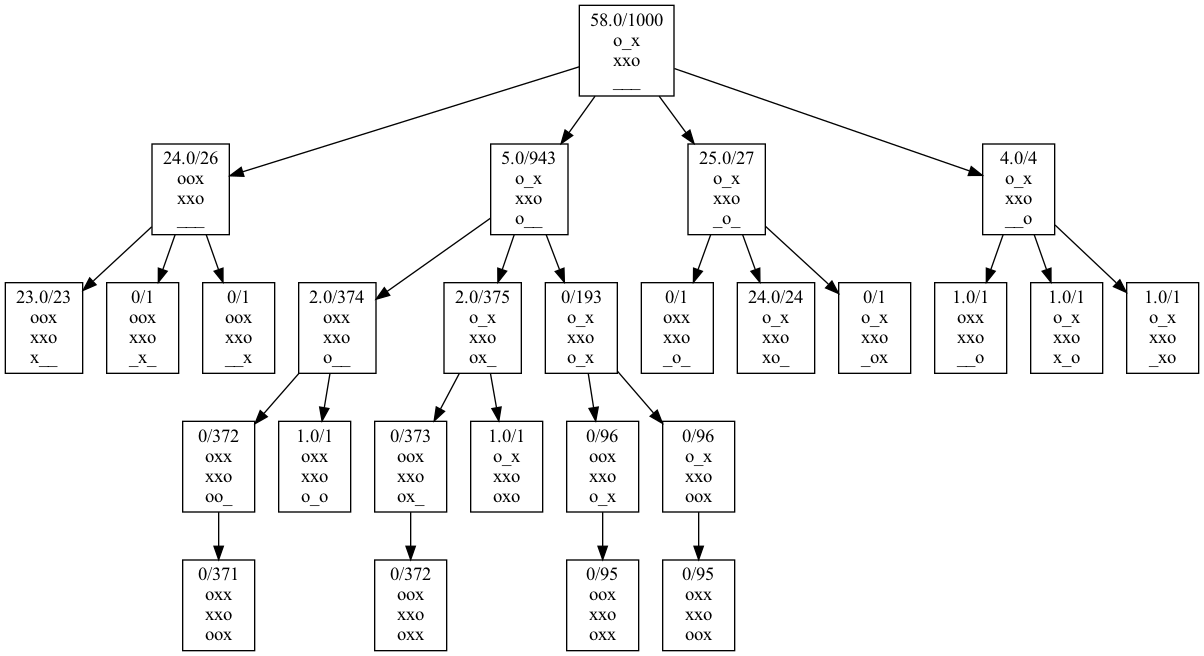

In [236]:
!dot -Tpng lab3_mcts_exp01_5.dot > lab3_mcts_exp01_5.png
Image('lab3_mcts_exp01_5.png')

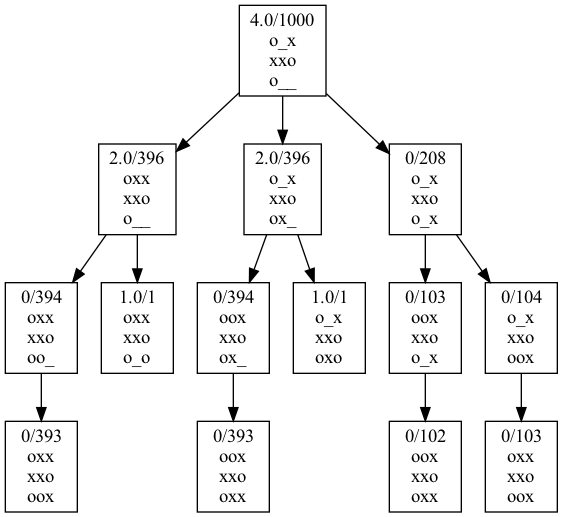

In [237]:
!dot -Tpng lab3_mcts_exp01_6.dot > lab3_mcts_exp01_6.png
Image('lab3_mcts_exp01_6.png')

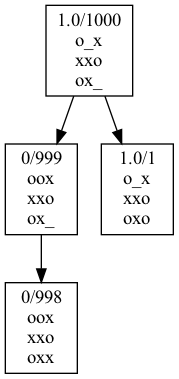

In [238]:
!dot -Tpng lab3_mcts_exp01_7.dot > lab3_mcts_exp01_7.png
Image('lab3_mcts_exp01_7.png')

**Observation:** On the contrary, the tree is smaller when decreasing the exploration rate, as we tend to exploit the solutions we already know to find the best move

### Exercise 6 (bonus): Use another rollout policy

For instance: the greedy policy

In [243]:
def greedy_policy(state: NaughtsAndCrossesState, epsilon: float = 0.1) -> NaughtsAndCrossesAction:
    """
    Select an action from the possible actions in the current state, following epsilon-greedy policy

    Parameters
    ----------
    state : NaughtsAndCrossesState
        The current state of the game.

    Returns
    -------
    NaughtsAndCrossesAction
        A randomly selected action from the possible actions in the current state.
    """
    ### BEGIN SOLUTION ###
    possible_actions = state.getPossibleActions()

    rdm_value = random.random()

    if(rdm_value < epsilon):
        action = random.choice(possible_actions)

    else: # We take the best action to play
        best_rwd = -math.inf
        
        next_player = -state.getCurrentPlayer()
        for action in possible_actions:
            possible_state = state.takeAction(action)
            rwd = possible_state.getReward()
            if(rwd > best_rwd):
                best_rwd = rwd * next_player
                best_action = action

    ### END SOLUTION ###

    return action

In [244]:
root_state = NaughtsAndCrossesState()
root_node = TreeNode(root_state, None)
root_node.to_graphiz(save_file_path=f"lab3_mcts_initial.dot");

mcts = MCTS(exploration_ratio=1/math.sqrt(2), rollout_policy=greedy_policy)

state = root_state

i = 0
while not state.isTerminal():
    ### BEGIN SOLUTION ###

    action = mcts.search(state, num_simulations=1000, log_steps=False)
    state = state.takeAction(action)

    ### END SOLUTION ###

    print(f"State: {state}")
    print(f"Action: {action}")
    print()

    mcts.root.to_graphiz(save_file_path=f"lab3_mcts_greedy_{i}.dot")

    i += 1

State: Current player: O
_ _ _
_ X _
_ _ _

Action: (1, 1)

State: Current player: X
_ _ _
_ X _
_ _ O

Action: (2, 2)

State: Current player: O
_ _ _
_ X X
_ _ O

Action: (1, 2)

State: Current player: X
_ _ _
O X X
_ _ O

Action: (1, 0)

State: Current player: O
_ _ _
O X X
X _ O

Action: (2, 0)

State: Current player: X
_ _ O
O X X
X _ O

Action: (0, 2)

State: Current player: O
_ _ O
O X X
X X O

Action: (2, 1)

State: Current player: X
_ O O
O X X
X X O

Action: (0, 1)

State: Current player: O
X O O
O X X
X X O

Action: (0, 0)



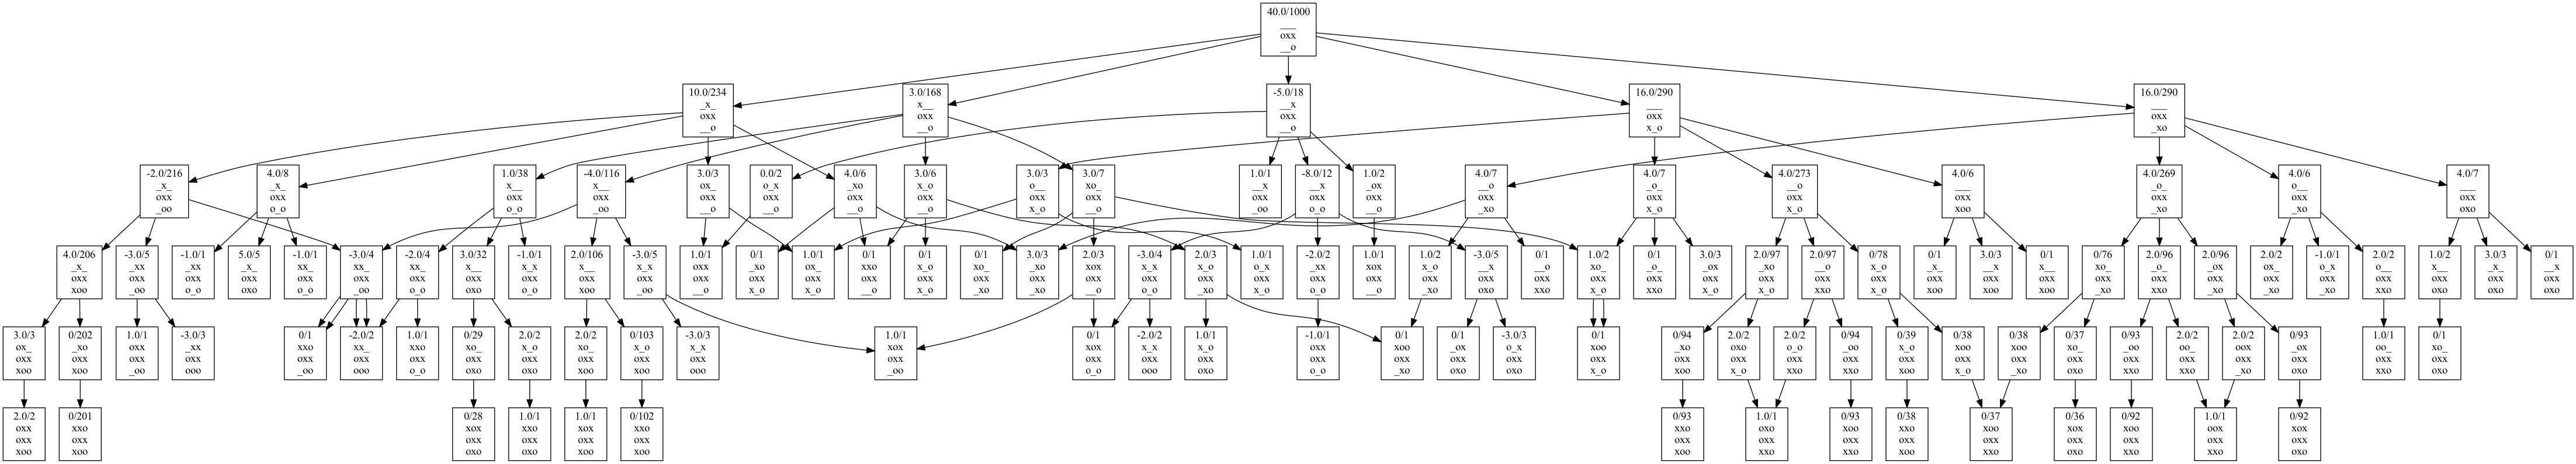

In [245]:
!dot -Tpng lab3_mcts_greedy_4.dot > lab3_mcts_greedy_4.png
Image('lab3_mcts_greedy_4.png')

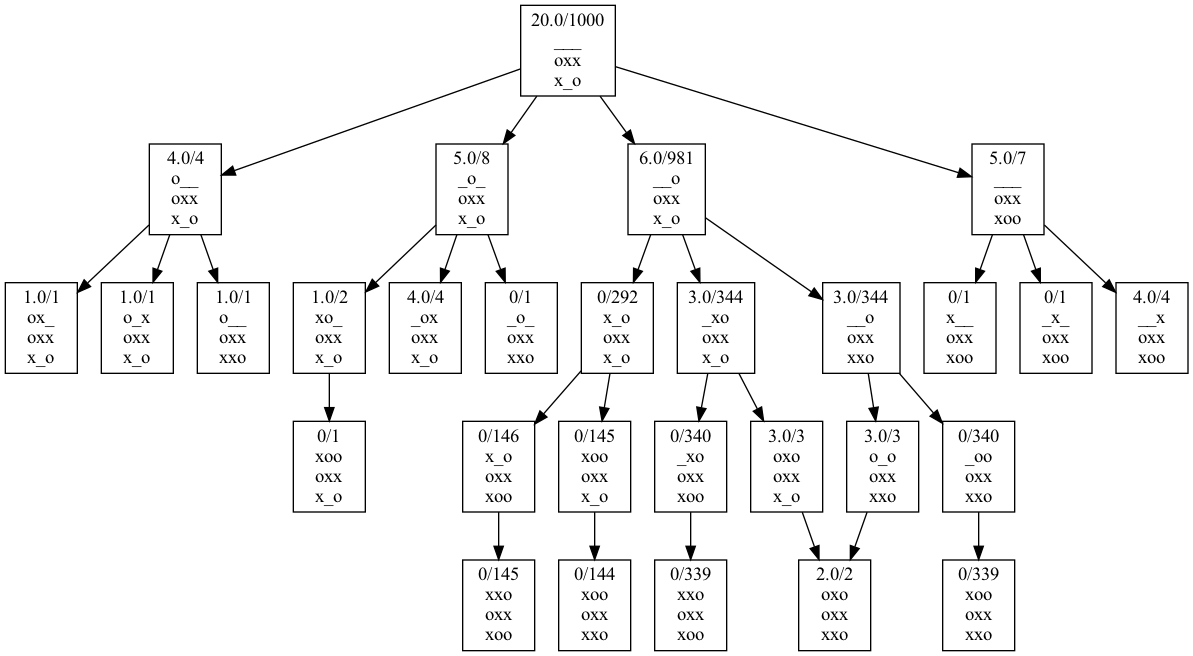

In [246]:
!dot -Tpng lab3_mcts_greedy_5.dot > lab3_mcts_greedy_5.png
Image('lab3_mcts_greedy_5.png')

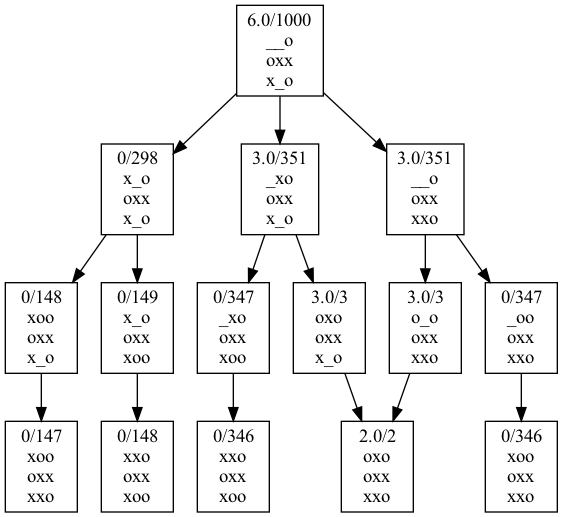

In [247]:
!dot -Tpng lab3_mcts_greedy_6.dot > lab3_mcts_greedy_6.png
Image('lab3_mcts_greedy_6.png')

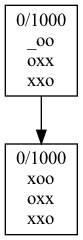

In [248]:
!dot -Tpng lab3_mcts_greedy_8.dot > lab3_mcts_greedy_8.png
Image('lab3_mcts_greedy_8.png')

**Observation:** The results are similar with an *epsilon-greedy policy* as a rollout policy. The TicTacToe game ends quite fast, so we don't have to make a crucial choice between exploration and exploitation during the simulations to estimate the value of the leaf properly. However, if we were to work in bigger environments, *epsilon-greedy policy* will provide more accurrate results than *random policy* about the value of a state.

# Bibliography

- Kocsis, Levente, and Csaba Szepesvári. "Bandit based monte-carlo planning." In European conference on machine learning, pp. 282-293. Berlin, Heidelberg: Springer Berlin Heidelberg, 2006. https://citeseerx.ist.psu.edu/document?repid=rep1&type=pdf&doi=6661e57237e4e8739b7a4946c4d3d4875376c068

- Browne, Cameron B., Edward Powley, Daniel Whitehouse, Simon M. Lucas, Peter I. Cowling, Philipp Rohlfshagen, Stephen Tavener, Diego Perez, Spyridon Samothrakis, and Simon Colton. "A survey of monte carlo tree search methods." IEEE Transactions on Computational Intelligence and AI in games 4, no. 1 (2012): 1-43. https://repository.essex.ac.uk/4117/1/MCTS-Survey.pdf

- Multi-armed Bandits: Richard S. Sutton and Andrew G. Barto: "Reinforcement Learning: An Introduction", chap.2 (http://incompleteideas.net/book/RLbook2020.pdf).

- Introduction to MCTS: Richard S. Sutton and Andrew G. Barto: "Reinforcement Learning: An Introduction", sect. 8.11, p.185 (http://incompleteideas.net/book/RLbook2020.pdf).

- Kamil Czarnogòrski, "Monte Carlo Tree Search – beginners guide", 2018 https://int8.io/monte-carlo-tree-search-beginners-guide/

- Auer, Peter, Nicolo Cesa-Bianchi, and Paul Fischer. "Finite-time analysis of the multiarmed bandit problem." Machine learning 47 (2002): 235-256. https://link.springer.com/content/pdf/10.1023/A:1013689704352.pdf

- Couëtoux, Adrien, Jean-Baptiste Hoock, Nataliya Sokolovska, Olivier Teytaud, and Nicolas Bonnard. "Continuous upper confidence trees." In Learning and Intelligent Optimization: 5th International Conference, LION 5, Rome, Italy, January 17-21, 2011. Selected Papers 5, pp. 433-445. Springer Berlin Heidelberg, 2011. https://hal.science/hal-00542673/file/c0mcts.pdf